## Imports


In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0) Notes & configuration


- Energy model prediction is in log10-space.


### File paths


In [18]:
energy_test_predictions_path = Path("energy") / "test_predictions.csv"
zenith_test_predictions_path = Path("zenith") / "test_predictions.csv"
azimuth_test_predictions_path = Path("azimuth") / "test_predictions.csv"



energy_metrics_path = Path("energy") / "metrics.csv"
zenith_metrics_path = Path("zenith") / "metrics.csv"
azimuth_metrics_path = Path("azimuth") / "metrics.csv"



df_energy_test_predictions = pd.read_csv(energy_test_predictions_path)
df_zenith_test_predictions = pd.read_csv(zenith_test_predictions_path)
df_azimuth_test_predictions = pd.read_csv(azimuth_test_predictions_path)


## 1) test_predictions.csv


### 1.a) Energy


Flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [ ]:
print("shape:", df_energy_test_predictions.shape)
print("columns:", list(df_energy_test_predictions.columns))

In [ ]:
df_energy_test_predictions["true_log10_energy"] = np.log10(df_energy_test_predictions["true_energy"].astype(float))

In [ ]:
df_energy_test_predictions.head(3)

In [ ]:
print("Rows:", len(df_energy_test_predictions))

print("\nNaN counts (all columns):")
print(df_energy_test_predictions.isna().sum())


In [ ]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_energy_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


In [ ]:
# true_energy <= 0 check 
true_e = pd.to_numeric(df_energy_test_predictions["true_energy"], errors="coerce")
print("\ntrue_energy <= 0:", (true_e <= 0).sum())

#### Energy overview

In [ ]:
# ---- Energy: global W over the full test set ----
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

In [ ]:
# ---- Energy: residual_log10 histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("residual_log10")
plt.ylabel("count")
plt.title("Residual (log10) histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Residual vs true energy (with binned median)

This diagnostic shows how the **log10 residual** behaves across the energy range:

- Each blue point is one event:  
  $r = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$  
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across energies.
- If it drifts above 0 → systematic **overestimation**.
- If it drifts below 0 → systematic **underestimation**.
- If the vertical spread increases with energy → **worsening resolution** (larger event-to-event scatter).



In [ ]:
# ---- Energy: residual vs true_log10_energy scatter + binned median ----

x = df_energy_test_predictions["true_log10_energy"].to_numpy(dtype=float)
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)

plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

# plot median curve
plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")

# reference line
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("log10(true_energy)")
plt.ylabel("residual_log10")
plt.title("Residual vs true energy (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Calibration scatter (predicted vs true)

A calibration plot compares the model prediction to the truth directly:

- x-axis: $\log_{10}(E_\mathrm{true})$  
- y-axis: $\widehat{\log_{10}E}$

The reference line $y=x$ corresponds to perfect calibration.
Points below the line indicate underestimation; above the line indicate overestimation.


In [ ]:
# ---- Energy: calibration scatter (pred_log10 vs true_log10) ----

plt.figure(figsize=(7, 6))  # bigger figure

plt.scatter(
    df_energy_test_predictions["true_log10_energy"],
    df_energy_test_predictions["pred_log10_energy"],
    s=6, alpha=0.2
)

xmin = df_energy_test_predictions["true_log10_energy"].min()
xmax = df_energy_test_predictions["true_log10_energy"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x in black

plt.xlabel("log10(true_E)")
plt.ylabel("pred_log10_energy")
plt.title("Energy calibration: predicted vs true (log10-space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Energy: histogram with counts annotated on top of bars ----
n_bins_energy = 10
bins_energy = np.linspace(
    df_energy_test_predictions["true_log10_energy"].min(),
    df_energy_test_predictions["true_log10_energy"].max(),
    n_bins_energy + 1,
)
values = df_energy_test_predictions["true_log10_energy"].to_numpy()

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_energy)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("log10(true_E)")
plt.ylabel("count")
plt.title("Energy histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
df_energy_w_rows = []
for left, right in zip(edges[:-1], edges[1:]):
    # select events in this bin (match matplotlib hist logic: [left, right) except last bin includes right)
    if right == edges[-1]:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] <= right)
    else:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] < right)

    r = df_energy_test_predictions.loc[mask, "residual_log10"].to_numpy(dtype=float)

    # skip empty bins (shouldn't happen, but safe)
    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_energy_w_rows.append({
        "Ebin": f"({left:.3f}, {right:.3f}]",
        "E_center_log10": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table = pd.DataFrame(df_energy_w_rows)
df_energy_W_table


In [ ]:
# ---- Energy: plot W vs true energy (equal-width bins) ----

plt.figure()
plt.plot(df_energy_W_table["E_center_log10"], df_energy_W_table["W"], marker="o")
plt.xlabel("log10(true_E) bin center")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


### Interpreting the W trend (equal-width bins)

In the **equal-width** energy binning, the number of events per bin is **not uniform**.  
At higher energies the bins contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens rapidly with energy.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [ ]:
# ---- create equal-population bins (qcut) ----

n_qbins_energy = 10

df_energy_test_predictions["Ebin_q"] = pd.qcut(
    df_energy_test_predictions["true_log10_energy"],
    q=n_qbins_energy,
    duplicates="drop",
)


In [ ]:
# ----  plot counts per qcut bin ----

bin_counts_q = df_energy_test_predictions["Ebin_q"].value_counts().sort_index()

plt.figure()
bars = plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(range(len(bin_counts_q)), [str(i) for i in bin_counts_q.index], rotation=45, ha="right")
plt.xlabel("qcut energy bin (log (true_E))")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# ---- Visualize qcut bin widths only (in log10-space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("log10(true_E)")
plt.title("qcut bin widths (Δlog10E)")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Energy: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_energy_q = []
for iv, g in df_energy_test_predictions.groupby("Ebin_q", observed=True):
    r = g["residual_log10"].to_numpy(dtype=float)

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_energy_q.append({
        "Ebin_q": str(iv),
        "E_center_log10": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table_q = pd.DataFrame(rows_energy_q).sort_values("E_center_log10")
df_energy_W_table_q


In [ ]:
# ---- Energy: plot W vs true energy (qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["W"], marker="o")
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


## Why `residual_log10`?

I analyze the prediction error in **log10-space** using `residual_log10`.  
This is especially convenient when the energy spans many orders of magnitude.


## Definition of `residual_log10`

`residual_log10` is defined as:

$ \mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true}) $

In the CSV this corresponds to:

$ \mathrm{residual\_log10} = \mathrm{pred\_log10\_energy} - \log_{10}(\mathrm{true\_energy}) $


## Interpreting the sign of `residual_log10`

- `residual_log10 = 0` → perfect prediction  
- `residual_log10 > 0` → the model **overpredicts** energy  
- `residual_log10 < 0` → the model **underpredicts** energy


## Quantiles: p16, p50, p84

To summarize the distribution of `residual_log10`:

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If the residuals were Gaussian, these would roughly correspond to **±1σ** around the median.)


## Resolution proxy: W

I define a resolution-like width using the central 68% interval:

$ W = \frac{p84 - p16}{2} $

Interpretation:
- **Small W** → tighter residual distribution → **better resolution**
- **Large W** → wider residual distribution → **worse resolution**

**Note:** W is measured in **log10-error units**, not directly in “% error”.


## Energy performance so far: resolution (W)

So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the `residual_log10` distribution in each energy bin.

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the energy, and does this depend on energy?


## Bias analysis — three complementary views

There are three simple and complementary ways to study bias:

1) **Median residual vs energy**  
   Plot $p50(\mathrm{residual\_log10})$ as a function of energy.  
   This is the most direct bias measure in log-space.

2) **Median pred/true ratio vs energy**  
   Convert the median residual into a multiplicative ratio  
   $\mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50}$  
   to make the bias more intuitive.


### 1) Median residual vs energy (log-space bias)

If we define  
$\mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$,

then:

- $p50 \approx 0$ → unbiased in that energy region  
- $p50 > 0$ → overestimation  
- $p50 < 0$ → underestimation


In [ ]:
# ---- Energy: bias vs true energy (median residual, qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("p50(residual_log10)")
plt.title("Energy bias vs true energy (median residual)")
plt.grid(True, alpha=0.3)
plt.show()

### 2) Median pred/true ratio vs energy (intuitive bias)

Because the residual is in log10-space, it can be converted into a multiplicative ratio:

$ \frac{E_\mathrm{pred}}{E_\mathrm{true}} = 10^{\mathrm{residual\_log10}} $

So the median bias ratio per bin is:

$ \mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50} $

Interpretation:
- ratio ≈ 1 → unbiased
- ratio < 1 → underestimation
- ratio > 1 → overestimation


In [ ]:
# ---- Energy: bias as pred/true ratio (qcut bins) ----

df_energy_W_table_q["ratio50"] = 10 ** (df_energy_W_table_q["p50"])

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["ratio50"], marker="o")
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("median(pred/true) = 10^p50")
plt.title("Energy bias as pred/true ratio")
plt.grid(True, alpha=0.3)
plt.show()


### 1.b) Zenith

Flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [19]:
print("shape:", df_zenith_test_predictions.shape)
print("columns:", list(df_zenith_test_predictions.columns))

shape: (41311, 5)
columns: ['true_zenith', 'pred_zenith', 'abs_error_deg', 'kappa', 'event_id']


In [20]:
numeric_cols = df_zenith_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_zenith_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)

                     min            max
true_zenith     0.005549       3.129967
pred_zenith     0.053634       3.119514
abs_error_deg   0.000014     121.741241
kappa           1.244967     120.558090
event_id       18.000000  402910.000000


##### Column ranges (min / max)

The table above reports the **minimum** and **maximum** value observed in each **numeric** column of `df_zenith_test_predictions`.

**Units**
- `true_zenith` and `pred_zenith` are in **radians** (expected physical range: \[0, π\]).
- `abs_error_deg` is in **degrees**.
- `kappa` is **dimensionless** (concentration parameter).
- `event_id` is an **integer identifier** (unitless).

In [22]:
# --- 1) Rename radian columns to make units explicit ---
rename_map = {
    "true_zenith": "true_zenith_radian",
    "pred_zenith": "pred_zenith_radian",
    "kappa": "kappa",          # unchanged (unitless)
    "event_id": "event_id",    # unchanged
    "abs_error_deg": "abs_error_zenith_degree",  # already in degrees
}
df_zenith_test_predictions.rename(columns={k: v for k, v in rename_map.items() if k in df_zenith_test_predictions.columns}, inplace=True)

# --- 2) Compute signed residual in radians ---
df_zenith_test_predictions["residual_zenith_radian"] = df_zenith_test_predictions["pred_zenith_radian"] - df_zenith_test_predictions["true_zenith_radian"]

# --- 3) Create degree versions ---
rad2deg = 180.0 / np.pi
df_zenith_test_predictions["true_zenith_degree"] = df_zenith_test_predictions["true_zenith_radian"] * rad2deg
df_zenith_test_predictions["pred_zenith_degree"] = df_zenith_test_predictions["pred_zenith_radian"] * rad2deg
df_zenith_test_predictions["residual_zenith_degree"] = df_zenith_test_predictions["residual_zenith_radian"] * rad2deg

# Optional: also keep abs error in radians (consistent pair with abs_error_zenith_degree)
df_zenith_test_predictions["abs_error_zenith_radian"] = np.abs(df_zenith_test_predictions["residual_zenith_radian"])

# abs error of zenith angle in radians (|pred - true|)
df_zenith_test_predictions["abs_error_zenith_radian"] = np.abs(
    df_zenith_test_predictions["pred_zenith_radian"] - df_zenith_test_predictions["true_zenith_radian"]
)

# quick check
print("columns:", list(df_zenith_test_predictions.columns))
df_zenith_test_predictions.head()


columns: ['true_zenith_radian', 'pred_zenith_radian', 'abs_error_zenith_degree', 'kappa', 'event_id', 'residual_zenith_radian', 'true_zenith_degree', 'pred_zenith_degree', 'residual_zenith_degree', 'abs_error_zenith_radian']


,true_zenith_radian,pred_zenith_radian,abs_error_zenith_degree,kappa,event_id,residual_zenith_radian,true_zenith_degree,pred_zenith_degree,residual_zenith_degree,abs_error_zenith_radian
0,0.390769,1.113049,41.383644,8.293178,242,0.722281,22.389387,63.773032,41.383645,0.722281
1,1.441897,1.440086,0.103778,99.067955,778,-0.001811,82.614621,82.510844,-0.103778,0.001811
2,1.758793,1.744501,0.818919,89.692795,1171,-0.014293,100.771443,99.952524,-0.818919,0.014293
3,2.018402,2.077291,3.374086,94.350357,1634,0.058889,115.645908,119.019994,3.374086,0.058889
4,0.521355,0.350702,9.777667,77.596909,3741,-0.170652,29.871426,20.093759,-9.777667,0.170652


In [23]:
print("Rows:", len(df_zenith_test_predictions))

print("\nNaN counts (all columns):")
print(df_zenith_test_predictions.isna().sum())

Rows: 41311

NaN counts (all columns):
true_zenith_radian         0
pred_zenith_radian         0
abs_error_zenith_degree    0
kappa                      0
event_id                   0
residual_zenith_radian     0
true_zenith_degree         0
pred_zenith_degree         0
residual_zenith_degree     0
abs_error_zenith_radian    0
dtype: int64


In [24]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_zenith_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)

Inf counts (numeric columns):
                         +inf  -inf  any_inf
true_zenith_radian          0     0        0
pred_zenith_radian          0     0        0
abs_error_zenith_degree     0     0        0
kappa                       0     0        0
event_id                    0     0        0
residual_zenith_radian      0     0        0
true_zenith_degree          0     0        0
pred_zenith_degree          0     0        0
residual_zenith_degree      0     0        0
abs_error_zenith_radian     0     0        0


#### Zenith overview

In [25]:
# ---- Energy: global W over the full test set ----
r = df_zenith_test_predictions["residual_zenith_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-3.1469, p50=0.2216, p84=3.6331, W=3.3900


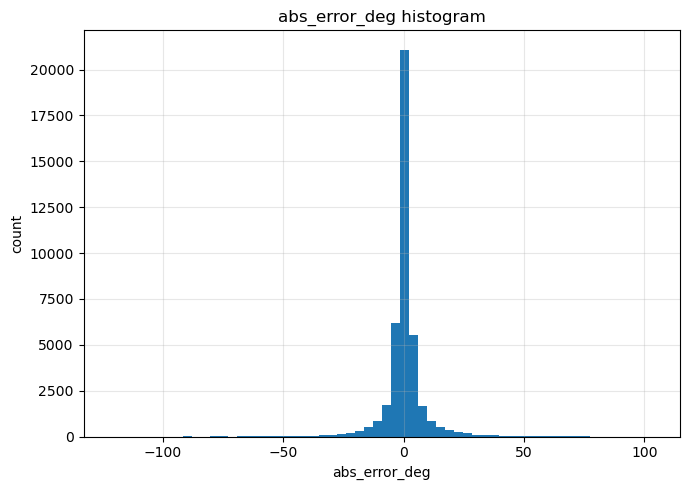

In [26]:
# ---- abs_error_deg histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("abs_error_deg")
plt.ylabel("count")
plt.title("abs_error_deg histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Residual vs true zenith (with binned median)

This diagnostic shows how the **zenith residual** behaves across the zenith range:

- Each blue point is one event:  
  $r = \widehat{\theta} - \theta_\mathrm{true}$  
  where $\theta$ is the zenith angle in **radians**.
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across zenith.
- If it drifts above 0 → systematic **overestimation** of zenith.
- If it drifts below 0 → systematic **underestimation** of zenith.
- If the vertical spread increases for certain zenith ranges → **worsening resolution** in those regions (larger event-to-event scatter).


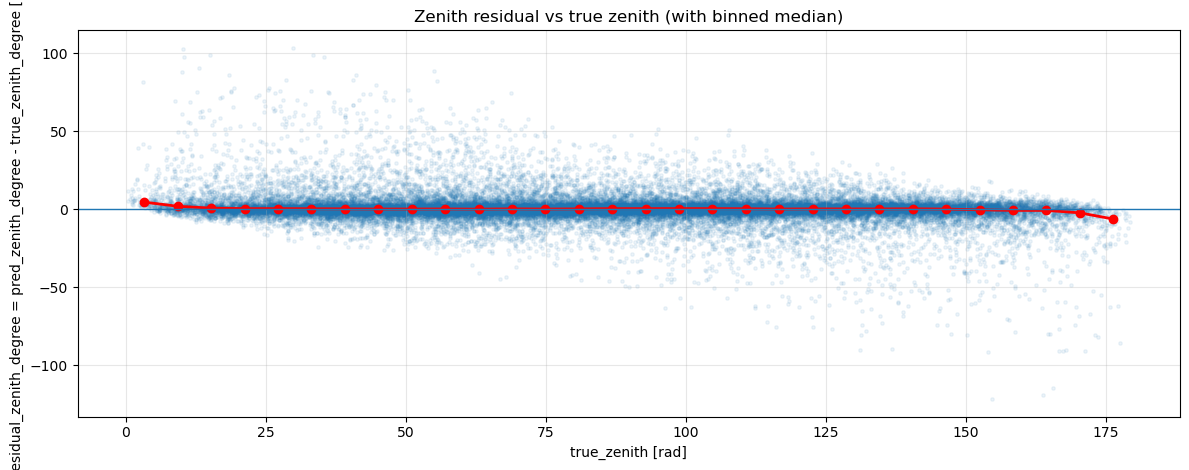

In [27]:
# ---- Zenith: residual vs true_zenith scatter + binned median (NO subsample) ----

x = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)
r = (
    df_zenith_test_predictions["pred_zenith_degree"].to_numpy(dtype=float)
    - df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)
)

plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_zenith [rad]")
plt.ylabel("residual_zenith_degree = pred_zenith_degree - true_zenith_degree [rad]")
plt.title("Zenith residual vs true zenith (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Calibration scatter (predicted vs true)

A calibration plot compares the model prediction to the truth directly:

- x-axis: $\theta_\mathrm{true}$ (zenith in **radians**)  
- y-axis: $\widehat{\theta}$ (predicted zenith in **radians**)

The reference line $y=x$ corresponds to perfect calibration.
Points below the line indicate underestimation; above the line indicate overestimation.


In [ ]:
# ---- Zenith: calibration scatter (pred_zenith vs true_zenith) ----

plt.figure(figsize=(7, 6))

plt.scatter(
    df_zenith_test_predictions["true_zenith"],
    df_zenith_test_predictions["pred_zenith"],
    s=6, alpha=0.2
)

xmin = df_zenith_test_predictions["true_zenith"].min()
xmax = df_zenith_test_predictions["true_zenith"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x

plt.xlabel("true_zenith [rad]")
plt.ylabel("pred_zenith [rad]")
plt.title("Zenith calibration: predicted vs true (radian space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Zenith: histogram with counts annotated on top of bars ----
n_bins_zenith = 10
bins_zenith = np.linspace(
    df_zenith_test_predictions["true_zenith"].min(),
    df_zenith_test_predictions["true_zenith"].max(),
    n_bins_zenith + 1,
)
values = df_zenith_test_predictions["true_zenith"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_zenith)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_zenith [rad]")
plt.ylabel("count")
plt.title("Zenith histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ---- Zenith: W table per zenith bin (using residual_zenith in radians) ----

df_zenith_w_rows = []

# residual in radians
residual_zenith = (
    df_zenith_test_predictions["pred_zenith"].to_numpy(dtype=float)
    - df_zenith_test_predictions["true_zenith"].to_numpy(dtype=float)
)

# Use histogram edges from your zenith hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_zenith, replace edges -> edges_zenith below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_zenith_test_predictions["true_zenith"] >= left) & (df_zenith_test_predictions["true_zenith"] <= right)
    else:
        mask = (df_zenith_test_predictions["true_zenith"] >= left) & (df_zenith_test_predictions["true_zenith"] < right)

    r = residual_zenith[mask.to_numpy()]

    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_zenith_w_rows.append({
        "Zbin": f"({left:.3f}, {right:.3f}]",
        "Z_center_rad": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table = pd.DataFrame(df_zenith_w_rows)
df_zenith_W_table


In [ ]:
# ---- Zenith: plot W vs true zenith (equal-width bins) ----

plt.figure()
plt.plot(df_zenith_W_table["Z_center_rad"], df_zenith_W_table["W"], marker="o")
plt.xlabel("true_zenith bin center [rad]")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [rad])")
plt.title("Zenith resolution (W) vs true zenith (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


### Interpreting the W trend (equal-width bins)

In the **equal-width** zenith binning, the number of events per bin is **not uniform**.  
Depending on the underlying event distribution, some zenith regions may contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens in those zenith ranges.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [ ]:
# ---- create equal-population bins (qcut) ----

n_qbins_zenith = 10

df_zenith_test_predictions["Zbin_q"] = pd.qcut(
    df_zenith_test_predictions["true_zenith"],
    q=n_qbins_zenith,
    duplicates="drop",
)


In [ ]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_zenith_test_predictions["Zbin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut zenith bin (true_zenith [rad])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# ---- Visualize qcut bin widths only (in zenith radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_zenith [rad]")
plt.title("qcut bin widths (Δzenith [rad])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Zenith: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_zenith_q = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["pred_zenith"] - g["true_zenith"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_zenith_q.append({
        "Zbin_q": str(iv),
        "Z_center_rad": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table_q = pd.DataFrame(rows_zenith_q).sort_values("Z_center_rad")
df_zenith_W_table_q


In [ ]:
# ---- Zenith: plot W vs true zenith (qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_rad"], df_zenith_W_table_q["W"], marker="o")
plt.xlabel("true_zenith bin center [rad] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [rad])")
plt.title("Zenith resolution (W) vs true zenith (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
## so far, we were interested in absolute error in angle. change it. then add some explanations here as in energy

## Zenith performance so far: resolution (W)

So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the **zenith residual** distribution  
$r = \widehat{\theta} - \theta_\mathrm{true}$ in each zenith bin (units: **radians**).

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the zenith angle, and does this depend on zenith?


#### Bias analysis — three complementary views

There are three simple and complementary ways to study bias:

1) **Median residual vs zenith**  
   Plot $p50(r)$ as a function of zenith, where  
   $r = \widehat{\theta} - \theta_\mathrm{true}$ (radians).  
   This is the most direct bias measure in angular space.

2) **Median absolute error vs zenith**  
   Plot the median of the absolute error (e.g., $p50(|r|)$ in radians, or equivalently in degrees).  
   This makes the typical angular deviation easier to interpret than signed residuals.

3) **Signed residual distribution by zenith bin**  
   Compare the residual distributions across zenith bins (e.g., boxplots or violin plots).  
   This shows whether certain zenith regions have systematic shifts (bias) and/or heavier tails.


### 1) Median residual vs zenith (angular bias)

If we define the zenith residual (in radians) as  
$r = \widehat{\theta} - \theta_\mathrm{true}$,

then:

- $p50 \approx 0$ → unbiased in that zenith region  
- $p50 > 0$ → systematic overestimation of zenith  
- $p50 < 0$ → systematic underestimation of zenith


In [ ]:
# ---- Zenith: bias vs true zenith (median residual, qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_rad"], df_zenith_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_zenith bin center [rad] (qcut)")
plt.ylabel("p50(residual_zenith) [rad]")
plt.title("Zenith bias vs true zenith (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


### 2) Median absolute error vs zenith (intuitive)

Because the signed residual can cancel out, it is also useful to track the typical *magnitude* of the error:

- $p50(|r|)$ in **radians** (or convert to degrees for readability)

Interpretation:
- smaller values → better angular accuracy
- larger values → worse angular accuracy in that zenith region


In [ ]:
# ---- Zenith: median absolute error vs true zenith (qcut bins) ----

df_zenith_W_table_q["abs_p50_rad"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["pred_zenith"] - g["true_zenith"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_zenith_W_table_q["abs_p50_rad"] = df_zenith_W_table_q["Zbin_q"].map(abs_map)

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_rad"], df_zenith_W_table_q["abs_p50_rad"], marker="o")
plt.xlabel("true_zenith bin center [rad] (qcut)")
plt.ylabel("median(|residual_zenith|) [rad]")
plt.title("Zenith accuracy vs true zenith (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()


### 1.c) Azimuth

Flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [ ]:
print("shape:", df_azimuth_test_predictions.shape)
print("columns:", list(df_azimuth_test_predictions.columns))

In [ ]:
numeric_cols = df_azimuth_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_azimuth_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)


##### Column ranges (min / max)

The table above reports the **minimum** and **maximum** value observed in each **numeric** column of `df_azimuth_test_predictions`.

**Units**
- `true_azimuth` and `pred_azimuth` are in **radians** (expected physical range: \[0, 2π\]).
- `abs_error_deg` is in **degrees**.
- `kappa` is **dimensionless** (concentration parameter).
- `event_id` is an **integer identifier** (unitless).

In [ ]:
print("Rows:", len(df_azimuth_test_predictions))

print("\nNaN counts (all columns):")
print(df_azimuth_test_predictions.isna().sum())


In [ ]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_azimuth_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


#### Azimuth overview

In [ ]:
# ---- Energy: global W over the full test set ----
r = df_azimuth_test_predictions["abs_error_deg"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

In [ ]:
# ---- abs_error_deg histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("abs_error_deg")
plt.ylabel("count")
plt.title("abs_error_deg histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2) metrics.csv


### Energy

Train/validation loss curves from `metrics.csv`.


In [ ]:
df_energy_metrics = pd.read_csv(energy_metrics_path)




print("shape:", df_energy_metrics.shape)
print("columns:", list(df_energy_metrics.columns))

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_energy_metrics["epoch"], df_energy_metrics["train_loss"], label="train_loss")
plt.plot(df_energy_metrics["epoch"], df_energy_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Zenith

*(Heading only — fill in later.)*


### Azimuth

*(Heading only — fill in later.)*


## 3) resources_and_time.csv


### Energy

*(Optional: add runtime / GPU/CPU resource plots here.)*


### Zenith

*(Heading only — fill in later.)*


### Azimuth

*(Heading only — fill in later.)*


## Appendix: Moved scratch / placeholder cells (kept unchanged)

This section contains the original empty cells / duplicate headings / early drafts.
They are kept to ensure **nothing is removed**, but moved out of the main flow.


### 1.b) Zenith (scratch / moved to Appendix)


In [ ]:
df_zenith_test_predictions = pd.read_csv(zenith_test_predictions_path)

print("shape:", df_zenith_test_predictions.shape)
print("columns:", list(df_zenith_test_predictions.columns))


In [ ]:
df_zenith_test_predictions.head(3)

### Zenith (duplicate section — moved to Appendix)


#### test_predictions.csv


#### resources_and_time.csv


#### metrics.csv


### Azimuth (duplicate section — moved to Appendix)


#### test_predictions.csv


#### resources_and_time.csv


#### metrics.csv
